# Practico 3 y 4 (parte 2)
## Inclusion de librerias y módulos

In [1]:
# Inclusion de librerias y módulos
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Separación
from sklearn.model_selection import train_test_split

# Gradiente Descendente
from sklearn.linear_model import SGDClassifier

# Árbol de Decisión
# from sklearn.tree import DecisionTreeClassifier, plot_tree

# Validación Cruzada de HP en grilla.
from sklearn.model_selection import GridSearchCV

# Normalización
from sklearn.preprocessing import StandardScaler

# Utiles
from utiles import basic_metrics
from utiles import plot_cm
from utiles import plot_roc_pr

# Colores
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

# Plot axes y legends parambs
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.shadow"]      = True
plt.rcParams["figure.titleweight"] = "bold"

## Carga, división y normalización de los datos

1. El archivo `yup_curated_data.csv` se genera a partir del archivo `yup_messages_preprocessed.csv` y `datadump-20150801-20171219.csv` y se cura para se utilizado en el presente notebook.

2. El conjunto de datos es dividido en el conjunto de datos de entrada o alimentacion y en la referencia o target al que debe apuntar el clasificador al momento de predecir.

3. En la segunda instancia de separación se divide el conjunto de datos en conjunto de datos de entrenamiento y conjunto de datos de test, cada uno de ellos con su correspondiente referencia o target.

4. Los conjuntos de datos, train y test, son normalizados para favofrecer el proceso de convergencia del modelo. Se remueve media y normaliza varianza a valor unitario. [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


In [2]:
#1. Carga del conjunto de datos curados
filename = 'yup_curated_data.csv'
dataset = pd.read_csv(os.path.join('..', 'dataset', filename))

#2. Dividimos entre entrada y referencia o target
X, y = dataset.iloc[:, :-1], dataset.student_rating_cat

#3. Division entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#4. Normalizamos los datos para mejorar convergencia
StdScaler = StandardScaler()
StdScaler.fit(X_train)
X_train = StdScaler.transform(X_train)
X_test  = StdScaler.transform(X_test)

## **Ejercicio 2.1: Clasificador Stochastic Gradient Descent**

Se crea el objeto del modelo y se imprimen los parametros por defecto que posee el modelo.

In [3]:
SGD = SGDClassifier(random_state=42)

print('Parámetros utilizados: \n', np.array(list(SGD.get_params(deep=False).items())))

Parámetros utilizados: 
 [['alpha' 0.0001]
 ['average' False]
 ['class_weight' None]
 ['early_stopping' False]
 ['epsilon' 0.1]
 ['eta0' 0.0]
 ['fit_intercept' True]
 ['l1_ratio' 0.15]
 ['learning_rate' 'optimal']
 ['loss' 'hinge']
 ['max_iter' 1000]
 ['n_iter_no_change' 5]
 ['n_jobs' None]
 ['penalty' 'l2']
 ['power_t' 0.5]
 ['random_state' 42]
 ['shuffle' True]
 ['tol' 0.001]
 ['validation_fraction' 0.1]
 ['verbose' 0]
 ['warm_start' False]]


### Entrenamiento

El modelo es entrenado con los parametros que posee la implementación por defecto. El mencionado proceso consume el conjunto de datos de entrenamiento y su correspondiente referencia.

In [4]:
SGD.fit(X_train, y_train)

SGDClassifier(random_state=42)

### Predicción con el conjuto de datos de entrenamient y test

Se lleva a cabo el proceso de prediccion tomando como entrada al modelo

1. El conjunto de datos de entrenamiento
2. El conjunto de datos de test

In [5]:
#1. Predicción con el conjunto de datos de entrenamiento
y_train_SGD = SGD.predict(X_train)
y_train_SGDp = SGD.decision_function(X_train)

#2. Predicción con el conjunto de datos de test
y_test_SGD = SGD.predict(X_test)
y_test_SGDp = SGD.decision_function(X_test)

#### Se imprimen las métricas de desempeño

* Accuracy
* Precision
* Recall
* F1-score
* Matriz de confusión

In [6]:
print('************************************************************')
cm_train = basic_metrics(y_train, y_train_SGD, 'Train')
print('------------------------------------------------------------')
cm_test = basic_metrics(y_test, y_test_SGD, 'Test')
print('------------------------------------------------------------')

************************************************************
Métricas Train:
              precision    recall  f1-score   support

           0      0.706     0.153     0.252      2899
           1      0.816     0.983     0.892     11044

    accuracy                          0.811     13943
   macro avg      0.761     0.568     0.572     13943
weighted avg      0.793     0.811     0.759     13943

Confusion Matrix: 
[[  444  2455]
 [  185 10859]]
------------------------------------------------------------
Métricas Test:
              precision    recall  f1-score   support

           0      0.669     0.119     0.202       699
           1      0.817     0.985     0.893      2787

    accuracy                          0.812      3486
   macro avg      0.743     0.552     0.547      3486
weighted avg      0.787     0.812     0.755      3486

Confusion Matrix: 
[[  83  616]
 [  41 2746]]
------------------------------------------------------------


### Matrices de confusion para conjunto de entrenamiento y prueba

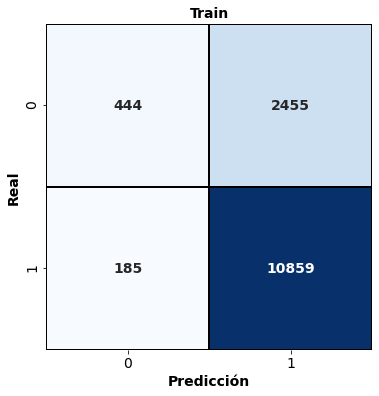

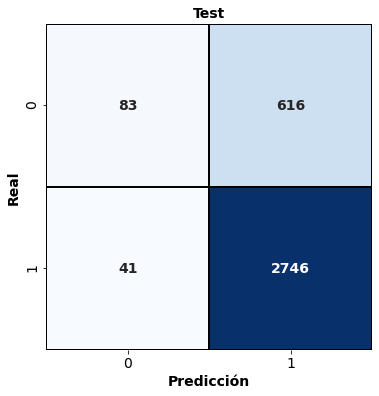

In [7]:
# Train Matriz de confusion
plot_cm(cm_train, figsize=(10,6), title='Train', cmap='Blues');

# Test Matriz de confusion
plot_cm(cm_test, figsize=(10,6), title='Test', cmap='Blues');

### Curvas ROC y Precission vs. Recall para conjuto de entrenamiento y prueba

Una herramienta de análisis complementaria, global e independiente es la [curva ROC](https://es.wikipedia.org/wiki/Curva_ROC), del Inglés Receiver Operating Characteristic, que permite comparar desempeño de diferentes modelos respecto al ideal y al peor caso de operación. Es necesario destacar que también es posible utilizar las curvas ROC para comparar desemeño entre diferentes modelos. En particular, se emplea el área bajo la curva (AUC) ROC como la medida cuantificada de desempeño. Algunas convensione asumen lo siguiente

|Rango del AUC| Desempeño cuantificado|
|---|---|
| \[0.5\] | Aleatorio [1]|
| \[0.5, 0.6 ) | Malo |
| \[0.6, 0.75) | Regular|
| \[0.75, 0.9) | Bueno|
| \[0.9, 0.97) | Muy bueno|
| \[0.97, 1) | Excelente|

[1]: Es como lanzar una moneda.

La curva de [precision vs. recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py) is una medida util del éxito en la predicción cuando las clases no son balanceadas. Esta curva muestra la relación de compromiso entre ámbas métricas para diferentes umbrales. Mientras mayor sea el área debajo de la curva, esto indica mayor precision y recall en donde la primera se relaciona inversamente proporcional a la tasa de falsos positivos mientras que la segunda lo hace tambien en forma inversamente proporcional con la tasa de falsos negativos.

#### Analisis

De acuerdo a lo mencionado, a partir de la curva de ROC podemos concluir que el desempeño de nuestro modelo es **Regular** y que incurre en falsos positivos como se observa en la disminucion de la precision.


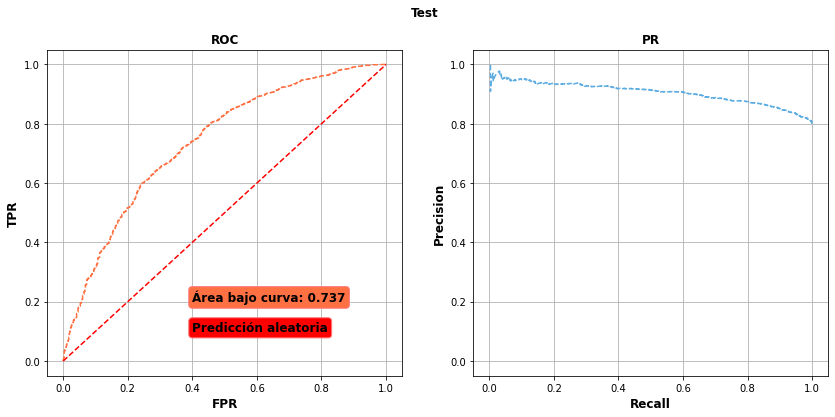

In [8]:
# plot_roc_pr(y_train, y_train_SGD, y_train_SGDp, Title='Train', x_text=0.4, y_text=0.2, size_text=12, size=(14,6), ms=15, colorR=RED, colorP=BLUE, label=None);
plot_roc_pr(y_test , y_test_SGD , y_test_SGDp , Title='Test' , x_text=0.4, y_text=0.2, size_text=12, size=(14,6), ms=15, colorR=RED, colorP=BLUE, label=None);

## **Ejercicio 2.2: Ajuste de Hiperparámetros**

Fijamos el aprámetro `penalty` en *elasticnet* con el objetivo de barrer el parámetro `l1_ratio` en el rango 0 a 1 lo que nos permite evaluar `penalty` desde *L2* a *L1* pasando por los valores intermedios.

In [9]:
SGD = SGDClassifier(penalty='elasticnet', random_state=42)

#### Opciones de parámetros

In [10]:
param_grid_GD2 = [
  {'learning_rate': ['constant', 'adaptive'],
          'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
          'l1_ratio': list(np.linspace(0, 1, 11))+[0.15], #Para que exista el Default
          'alpha': np.logspace(-5, 0, 6),
          'eta0': np.logspace(-5, 0, 6)
          },
  {'learning_rate': ['optimal'],
          'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
          'l1_ratio': list(np.linspace(0, 1, 11))+[0.15], #Para que exista el Default
          'alpha': np.logspace(-5, 0, 6),
          'eta0': [0] #No utilizado al ser Optimal
          }
]

#### Utilizamos grid-search con 5-fold cross-validation

Se van a ralizar 5 pliegues de datos para validación cruzada y se van reportar las siguientes métricas de desempeño:

* *accuracy*
* *precision_weighted*
* *recall_weighted*
* *f1_weighted*

y se instruye a `GridSearchCV` para que utilice todos los nucleos disponibles en el procesador empleado.

In [11]:
GSCV = GridSearchCV(SGD, param_grid_GD2, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], refit=False, n_jobs=-1, verbose=4)
GSCV.fit(X_train, y_train);

Fitting 5 folds for each of 3744 candidates, totalling 18720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 710 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1886 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2620 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3238 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4785 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 5348 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5961 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 6936 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8089 tasks      | e

Los resultados son formateados en un dataframe de pandas para poder encontrar las opciones más convenientes.

In [12]:
# Pasamos a DF los Resultados
Res_GSCV = pd.DataFrame(GSCV.cv_results_)

# Salvamos los resultados para analizarlos fuera del notebook
# Res_GSCV.to_csv('./results_to_analyze.csv')

# Imprimimos las columnas para tener una guia de los datos diponibles.
Res_GSCV.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta0', 'param_l1_ratio', 'param_learning_rate',
       'param_loss', 'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_precision_weighted', 'split1_test_precision_weighted',
       'split2_test_precision_weighted', 'split3_test_precision_weighted',
       'split4_test_precision_weighted', 'mean_test_precision_weighted',
       'std_test_precision_weighted', 'rank_test_precision_weighted',
       'split0_test_recall_weighted', 'split1_test_recall_weighted',
       'split2_test_recall_weighted', 'split3_test_recall_weighted',
       'split4_test_recall_weighted', 'mean_test_recall_weighted',
       'std_test_recall_weighted', 'rank_test_recall_weighted',
       'split0_test_f1_weighted', 'split1_test_f1_weig

In [13]:
Res_GSCV

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_eta0,param_l1_ratio,param_learning_rate,param_loss,params,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.198520,0.011682,0.016736,0.004490,1e-05,1e-05,0,constant,hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",...,0.002291,1501,0.744311,0.749892,0.753939,0.744939,0.757062,0.750029,0.004967,1728
1,0.351748,0.008676,0.011326,0.003329,1e-05,1e-05,0,constant,log,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",...,0.004075,31,0.755878,0.757872,0.768967,0.760270,0.771888,0.762975,0.006310,12
2,0.110239,0.031757,0.012520,0.003457,1e-05,1e-05,0,constant,modified_huber,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",...,0.003659,1114,0.749383,0.752591,0.760827,0.753869,0.765310,0.756396,0.005816,788
3,0.077449,0.003474,0.010016,0.000564,1e-05,1e-05,0,constant,squared_hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",...,0.003523,956,0.749629,0.753273,0.760827,0.753869,0.764918,0.756503,0.005552,660
4,0.176032,0.031920,0.020053,0.009550,1e-05,1e-05,0,adaptive,hinge,"{'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0....",...,0.002224,1645,0.744311,0.749892,0.753939,0.744939,0.757230,0.750062,0.005015,1710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,1.112755,1.337203,0.009735,0.001339,1,0,1,optimal,squared_hinge,"{'alpha': 1.0, 'eta0': 0, 'l1_ratio': 1.0, 'le...",...,0.033868,3285,0.705710,0.700127,0.700127,0.700024,0.700518,0.701301,0.002211,2988
3740,0.040021,0.002647,0.016159,0.008779,1,0,0.15,optimal,hinge,"{'alpha': 1.0, 'eta0': 0, 'l1_ratio': 0.15, 'l...",...,0.000124,2626,0.700127,0.700127,0.700127,0.700024,0.700518,0.700184,0.000171,3009
3741,0.055200,0.004449,0.012850,0.004327,1,0,0.15,optimal,log,"{'alpha': 1.0, 'eta0': 0, 'l1_ratio': 0.15, 'l...",...,0.000124,2626,0.700127,0.700127,0.700127,0.700024,0.700518,0.700184,0.000171,3009
3742,0.056064,0.010282,0.011500,0.001470,1,0,0.15,optimal,modified_huber,"{'alpha': 1.0, 'eta0': 0, 'l1_ratio': 0.15, 'l...",...,0.001051,2598,0.706908,0.700983,0.702687,0.700024,0.700518,0.702224,0.002508,2971


### Tomamos los parámetros de los modelos para la mejor de cada métrica

A los fines del análisis tomamos los parámetros de los modelos que mejor desempeño presentan para cada una de las métricas. Luego entrenamos un modelo para cada juego de parámetros a los fines de obtener mayor de talle de su desempeño. Finalemente seleccionaremos el model de mejor `F1-score` dado que no tenemos ninguna otra restricción definida y dicha métrica represnta un mayor compromiso de precision y recall.


In [14]:
best_accuracy = Res_GSCV.loc[Res_GSCV.rank_test_accuracy.idxmin()]
best_precision = Res_GSCV.loc[Res_GSCV.rank_test_precision_weighted.idxmin()]
best_recall = Res_GSCV.loc[Res_GSCV.rank_test_recall_weighted.idxmin()]
best_f1 = Res_GSCV.loc[Res_GSCV.rank_test_f1_weighted.idxmin()]

print('Parametros para las mejores metricas:\n'
      f'Accu: {best_accuracy.mean_test_accuracy:.2f}, params: {best_accuracy.params}\n'
      f'Prec: {best_precision.mean_test_precision_weighted:.2f}, params: {best_precision.params}\n'
      f'Reca: {best_recall.mean_test_recall_weighted:.2f}, params: {best_recall.params}\n'
     f'F1  : {best_f1.mean_test_f1_weighted:.2f}, params: {best_f1.params}\n'
     )

Parametros para las mejores metricas:
Accu: 0.81, params: {'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0.8, 'learning_rate': 'constant', 'loss': 'log'}
Prec: 0.81, params: {'alpha': 1.0, 'eta0': 1.0, 'l1_ratio': 0.15, 'learning_rate': 'adaptive', 'loss': 'modified_huber'}
Reca: 0.81, params: {'alpha': 1e-05, 'eta0': 1e-05, 'l1_ratio': 0.8, 'learning_rate': 'constant', 'loss': 'log'}
F1  : 0.76, params: {'alpha': 1e-05, 'eta0': 0, 'l1_ratio': 0.0, 'learning_rate': 'optimal', 'loss': 'log'}



### Entrenamos un modelo con la mejor configuración para cada métrica

In [15]:
SGD_accu = SGDClassifier(**best_accuracy.params, penalty='elasticnet', random_state=42)
SGD_prec = SGDClassifier(**best_precision.params, penalty='elasticnet', random_state=42)
SGD_reca = SGDClassifier(**best_recall.params, penalty='elasticnet', random_state=42)
SGD_f1  = SGDClassifier(**best_f1.params, penalty='elasticnet', random_state=42)

SGD_accu.fit(X_train, y_train);
SGD_prec.fit(X_train, y_train);
SGD_reca.fit(X_train, y_train);
SGD_f1.fit(X_train, y_train);

#### Corremos los modelos con el conjunto de entrenamiento y prueba

In [16]:
y_pred_accu_train = SGD_accu.predict(X_train)
y_pred_accu_test  =  SGD_accu.predict(X_test)

y_pred_prec_train = SGD_prec.predict(X_train)
y_pred_prec_test  = SGD_prec.predict(X_test)

y_pred_reca_train = SGD_reca.predict(X_train)
y_pred_reca_test =  SGD_reca.predict(X_test)

y_pred_f1_train = SGD_f1.predict(X_train)
y_pred_f1_test =  SGD_f1.predict(X_test)
y_test_f1_testp = SGD_f1.decision_function(X_test)

#### Se imprimen las métricas de desempeño para cada modelo

* Accuracy
* Precision
* Recall
* F1-score
* Matriz de confusión

In [17]:
# Accuracy
print('************************************************************')
cm_train_accu = basic_metrics(y_train, y_pred_accu_train, 'Accuracy Train')
print('------------------------------------------------------------')
cm_test_accu = basic_metrics(y_test, y_pred_accu_test, 'Accuracy Test')
print('------------------------------------------------------------\n\n')

# Precission
print('************************************************************')
cm_train_prec = basic_metrics(y_train, y_pred_prec_train, 'Precision Train')
print('------------------------------------------------------------')
cm_test_prec = basic_metrics(y_test, y_pred_prec_test, 'Precision Test')
print('------------------------------------------------------------\n\n')

# Recall
print('************************************************************')
cm_train_reca = basic_metrics(y_train, y_pred_reca_train, 'Recall Train')
print('------------------------------------------------------------')
cm_test_reca = basic_metrics(y_test, y_pred_reca_test, 'Recall Test')
print('------------------------------------------------------------\n\n')

# F1-score
print('************************************************************')
cm_train_f1 = basic_metrics(y_train, y_pred_f1_train, 'F1 Train')
print('------------------------------------------------------------')
cm_test_f1 = basic_metrics(y_test, y_pred_f1_test, 'F1 Test')
print('------------------------------------------------------------\n\n')

************************************************************
Métricas Accuracy Train:
              precision    recall  f1-score   support

           0      0.697     0.167     0.269      2899
           1      0.818     0.981     0.892     11044

    accuracy                          0.812     13943
   macro avg      0.758     0.574     0.581     13943
weighted avg      0.793     0.812     0.763     13943

Confusion Matrix: 
[[  484  2415]
 [  210 10834]]
------------------------------------------------------------
Métricas Accuracy Test:
              precision    recall  f1-score   support

           0      0.685     0.140     0.233       699
           1      0.820     0.984     0.895      2787

    accuracy                          0.815      3486
   macro avg      0.753     0.562     0.564      3486
weighted avg      0.793     0.815     0.762      3486

Confusion Matrix: 
[[  98  601]
 [  45 2742]]
------------------------------------------------------------


****************

#### Matriz de confusión para el modelo con mejor F1-score

Tomamos este modelo debido a que es el que tiene mejor balance de precision y recall

$
F_1 = \frac{2}{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}} = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{\mathrm tp}{\mathrm{tp} + \frac12 (\mathrm{fp} + \mathrm{fn}) } 
$

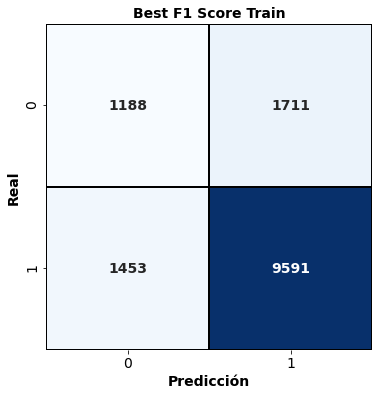

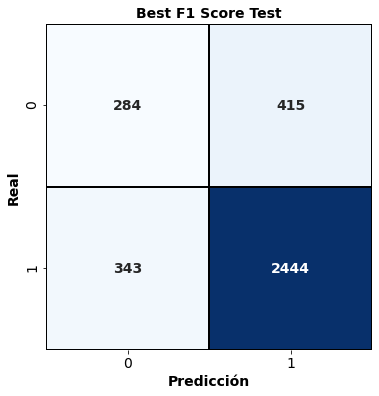

In [18]:
# Train Matriz de confusion
plot_cm(cm_train_f1, figsize=(10,6), title='Best F1 Score Train', cmap='Blues');

# Test Matriz de confusion
plot_cm(cm_test_f1, figsize=(10,6), title='Best F1 Score Test', cmap='Blues');

#### Curvas ROC y Precission vs. Recall para conjuto de entrenamiento y prueba

No se observa una mejora en el AUC, sin embargo, el modelo tiene un mejor equilibrio de precision y recall.

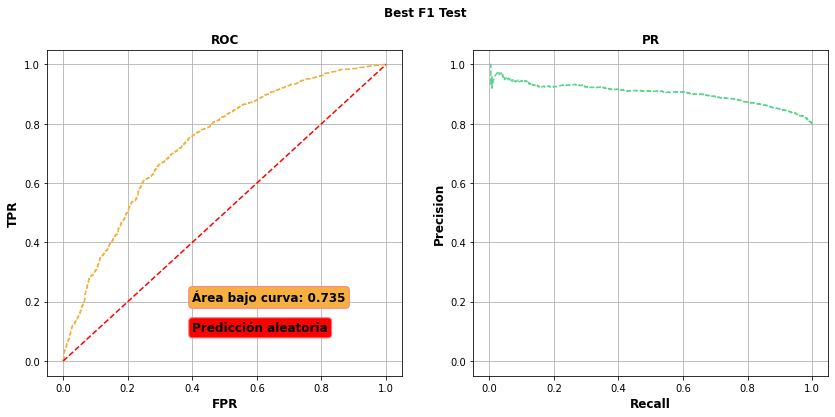

In [19]:
# plot_roc_pr(y_train, y_pred_f1_train, Title='Best F1 Train', x_text=0.4, y_text=0.2, size_text=12, size=(14,6), ms=15, colorR=ORANGE, colorP=GREEN, label=None);
plot_roc_pr(y_test,  y_pred_f1_test, y_test_f1_testp, Title='Best F1 Test',  x_text=0.4, y_text=0.2, size_text=12, size=(14,6), ms=15, colorR=ORANGE, colorP=GREEN, label=None);